# MNIST Handwritten Digit Classification - Recurrent Neural Networks

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.autograd import Variable
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

MODEL_FILE = os.path.join(DATA_DIR, "torch-mnist-rnn-{:d}.model")

LEARNING_RATE = 1e-3
ROWS, COLS = 28, 28
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 5

## Prepare Data

Torch LSTMs expect their data as 3D tensors of shape (SEQUENCE_LENGTH, BATCH_SIZE, EMBEDDING_SIZE), according to [this page](http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#lstm-s-in-pytorch). We do the data extraction below so our data is parsed out the same way.

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append(np.reshape(
            np.array([float(x) / 255. for x in cols[1:]]), 
            (COLS, ROWS)))
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    X = np.transpose(np.array(xdata), (1, 0, 2))
    y = np.array(ydata)
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(28, 60000, 28) (60000,) (28, 10000, 28) (10000,)


In [4]:
def datagen(X, y, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES):
    ohe = OneHotEncoder(n_values=num_classes)
    while True:
        shuffled_indices = np.random.permutation(np.arange(len(y)))
        num_batches = len(y) // batch_size
        for bid in range(num_batches):
            batch_indices = shuffled_indices[bid*batch_size:(bid+1)*batch_size]
            Xbatch = np.zeros((X.shape[0], batch_size, X.shape[2]))
            Ybatch = np.zeros((batch_size, num_classes))
            for i in range(batch_size):
                Xbatch[:, i, :] = X[:, batch_indices[i], :]
                Ybatch[i] = ohe.fit_transform(y[batch_indices[i]]).todense()
            yield Xbatch, Ybatch

self_test_gen = datagen(Xtrain, ytrain)
Xbatch, Ybatch = self_test_gen.next()
print(Xbatch.shape, Ybatch.shape)

(28, 128, 28) (128, 10)


## Define Network

In [5]:
class MNISTClassifier(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, 
                 seqlen, batch_size):
        super(MNISTClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seqlen = seqlen
        self.batch_size = batch_size
        self.output_dim = output_dim
        # define layers
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim)
        self.fcn = torch.nn.Linear(hidden_dim, output_dim)
        # define weights for LSTM
        self.hidden = self.init_hidden()


    def init_hidden(self):
        return (
            Variable(torch.randn(self.input_dim, self.batch_size, 
                                 self.hidden_dim)),
            Variable(torch.randn(self.input_dim, self.batch_size, 
                                 self.hidden_dim)))

    
    def forward(self, x):
        # LSTM
        lstm_out, self.hidden = self.lstm(x.view(self.input_dim, 
                                                 self.batch_size, 
                                                 self.seqlen), 
                                          self.hidden)
        # get the context vector (last element of lstm_out)
        lstm_out = lstm_out[-1]
        # dropout
        lstm_dropout = torch.nn.Dropout(p=0.2)(lstm_out)
        # FCN
        fcn_out = self.fcn(lstm_dropout.view(self.batch_size, 
                                             self.hidden_dim))
        return torch.nn.functional.log_softmax(fcn_out)

In [6]:
model = MNISTClassifier(ROWS, 512, NUM_CLASSES, COLS, BATCH_SIZE)
# loss_fn = torch.nn.NLLLoss()
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [7]:
def compute_accuracy(pred_var, true_var):
    ypred = np.argmax(pred_var.data.numpy(), axis=1)
    ytrue = np.argmax(true_var.data.numpy(), axis=1)
    return accuracy_score(ypred, ytrue)
    
history = []
train_gen = datagen(Xtrain, ytrain, BATCH_SIZE)
for epoch in range(NUM_EPOCHS):
    num_batches = Xtrain.shape[1] // BATCH_SIZE
    total_loss, total_acc = 0., 0.
    for _ in range(num_batches):
        # PyTorch accumulates gradients, so they need to be cleared
        # Hidden state needs to be cleared as well before each sequence
        model.zero_grad()
        model.hidden = model.init_hidden()
        # Get next batch, convert to Torch datatype
        Xbatch, Ybatch = train_gen.next()
        Xbatch = Variable(torch.from_numpy(Xbatch).float())
        Ybatch = Variable(torch.from_numpy(Ybatch).float())
        # forward
        Ybatch_ = model(Xbatch)
        # compute loss
        loss = loss_fn(Ybatch_, Ybatch)
        # zero parameter gradients
        loss.backward()
        total_loss += loss.data[0]
        total_acc += compute_accuracy(Ybatch_, Ybatch)
        optimizer.step()
    total_loss /= num_batches
    total_acc /= num_batches
    torch.save(model, MODEL_FILE.format(epoch+1))
    print("Epoch {:d}/{:d}: loss={:.3f}, accuracy={:.3f}".format(
            (epoch+1), NUM_EPOCHS, total_loss, total_acc))
    history.append((total_loss, total_acc))

/Users/palsujit/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type MNISTClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1/5: loss=5.845, accuracy=0.844
Epoch 2/5: loss=5.839, accuracy=0.969
Epoch 3/5: loss=5.839, accuracy=0.979
Epoch 4/5: loss=5.838, accuracy=0.984
Epoch 5/5: loss=5.838, accuracy=0.986


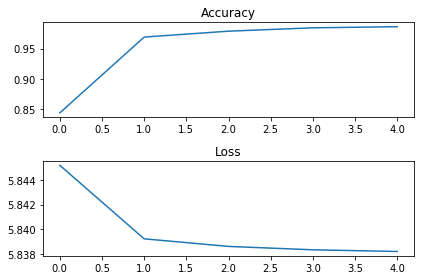

In [8]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Evaluate Network

In [18]:
BEST_MODEL_FILE = os.path.join(DATA_DIR, "torch-mnist-rnn-5.model")
model = torch.load(BEST_MODEL_FILE)

ys_, ys = [], []
test_gen = datagen(Xtest, ytest, BATCH_SIZE)
num_batches = Xtest.shape[1] // BATCH_SIZE
for _ in range(num_batches):
    Xbatch, Ybatch = test_gen.next()
    Xbatch = Variable(torch.from_numpy(Xbatch).float())
    Ybatch = Variable(torch.from_numpy(Ybatch).float())
    Ybatch_ = model(Xbatch)
    ys_.extend(np.argmax(Ybatch_.data.numpy(), axis=1))
    ys.extend(np.argmax(Ybatch.data.numpy(), axis=1))

acc = accuracy_score(ys_, ys)
cm = confusion_matrix(ys_, ys)
print("Accuracy: {:.4f}".format(acc))
print("Confusion Matrix")
print(cm)

Accuracy: 0.9836
Confusion Matrix
[[ 974    1    2    0    0    0    3    0    0    1]
 [   0 1130    1    1    0    0    2    5    0    1]
 [   0    1 1020    5    0    0    2    9    3    0]
 [   0    0    0  996    0   11    0    0    2    0]
 [   0    0    0    0  956    0    0    0    1    2]
 [   1    0    0    1    0  872   18    0    2    0]
 [   3    1    0    0    4    1  929    0    0    0]
 [   1    0    5    2    0    1    0  988    0    3]
 [   1    1    2    1    5    4    3    2  958    2]
 [   0    0    1    4   14    2    0   19    7  997]]
